In [1]:
import MDAnalysis as mda
import numpy as np
import mpl_toolkits.mplot3d as a3
import matplotlib.pyplot as plt
import sys,os
import math
import pandas as pd
from MDAnalysis.analysis import density
from scipy.spatial.distance import cdist
from gridData import Grid
from MDAnalysis.topology.guessers import guess_types
from tqdm import tqdm as tq
import mrcfile
from gridData import mrc
from gridData import OpenDX
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
import pylab as pl
from numpy import zeros, ones, arange, asarray, concatenate
from MDAnalysis.analysis.rms import RMSF
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import mixture
from matplotlib import rc

In [2]:
def write_pdb(name, coordinate):
    pdb = open(name, 'w')
    counter = 1
    for i in coordinate:
        pdb.write('ATOM  %5d  C   PTH     1    %8.3f%8.3f%8.3f%6.2f%6.2f\n'%(counter,i[0],i[1],i[2],0.0,0.0))
        counter += 1
    return
    

In [3]:
def Read_Protein_Coordinates(pdb,dcd,atom_selection):
    u = mda.Universe(pdb,dcd)
    protein = u.select_atoms(atom_selection)
    protein_coordinates = [protein.positions for ts in tq(u.trajectory)]
    return protein_coordinates, protein, u

In [7]:
protein_information= Read_Protein_Coordinates('trajectory/1jwp_noh.pdb',
                    'trajectory/1jwp_noh.dcd',
                    'protein and backbone and resid 30 to 280')

/usr/local/anaconda3/envs/RCs/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/usr/local/anaconda3/envs/RCs/lib/python3.8/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|          | 0/3204 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3204/3204 [00:00<00:00, 9791.00it/s]


Text(0, 0.5, 'RMSF')

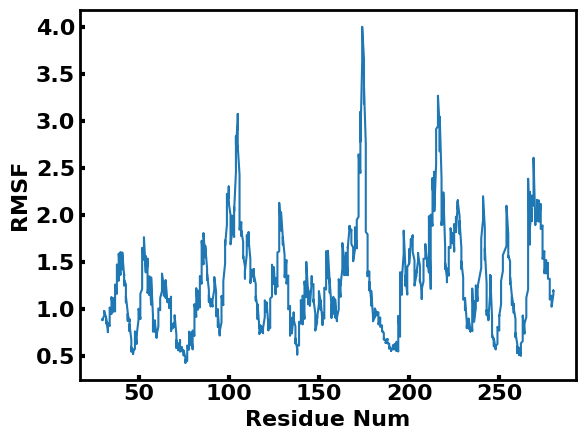

In [8]:
u = protein_information[2]
protein = protein_information[1]
calphas = protein.select_atoms("protein")
rmsfer = RMSF(calphas, verbose=True).run()
resid = calphas.resids
CA_Coordinates = np.array([calphas.positions for ts in tq(u.trajectory)])
CA_Coordinates_0 = CA_Coordinates[0]
rmsf = rmsfer.results.rmsf
font = {'style':'normal', 'size':'16', 'weight':'bold'}
rc('font', weight = 'bold')
rc('axes', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=16, width = 3, tickdir = 'in')
plt.plot(calphas.resnums[1:], rmsfer.results.rmsf[1:])
plt.xlabel("Residue Num",fontdict=font)
plt.ylabel("RMSF",fontdict=font)
#plt.axhline(y = avg_rmsf - std_rmsf*0.5, color = 'r', linewidth = 2)



In [12]:
avg_rmsf = np.average(rmsf)
CA_Coordinates_0_flex = CA_Coordinates_0 [np.where(rmsf >= avg_rmsf)[0]]
flex_resid = resid[np.where(rmsf >= avg_rmsf)[0]]
clf = mixture.BayesianGaussianMixture(
    n_components=10, 
    covariance_type="full", 
    weight_concentration_prior=1e2,
    weight_concentration_prior_type="dirichlet_process", 
    #mean_precision_prior=1e-2,
    #covariance_prior=1e0 * np.eye(2),
    #init_params="kmeans",
    max_iter=100,
    random_state=2
)
clf.fit(CA_Coordinates_0_flex)
label = clf.predict(CA_Coordinates_0_flex)
for i in range(10):
    write_pdb('flex_resi_'+str(i)+'.pdb',CA_Coordinates_0_flex[np.where(label == i)[0]] )
#flex_resid[np.where(label == 4)[0]]
